In [ ]:
# 统计 recognized 失败的样本个数
import glob

files = glob.glob('/home/ypw/data/doodle/train_simplified/*.csv')
len(files)
total = 0
for file in files:
    df = pd.read_csv(file)
    num = len(df)
    right = df.recognized.mean()
    total += num*(1-right)
print(total)

In [ ]:
files = glob.glob('/home/ypw/data/doodle/train_simplified/*.csv')
with tqdm(files) as pbar:
    for file in pbar:
        df = pd.read_csv(file)
        df = df[::10000]
        df['drawing'] = df['drawing'].apply(ast.literal_eval)
        df_x_max = max([max([max(stroke[0]) for stroke in value])for value in df.drawing])
        df_x_min = min([min([min(stroke[0]) for stroke in value])for value in df.drawing])
        df_y_max = max([max([max(stroke[1]) for stroke in value])for value in df.drawing])
        df_y_min = min([min([min(stroke[1]) for stroke in value])for value in df.drawing])
        label = (file.split('/')[-1]).split('.')[0]
        pbar.set_description(str((df_x_max, df_x_min, df_y_max, df_y_min, label)))

# Convert Strokes to RGB Images

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import ast
import cv2
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14

from tensorflow.keras.applications.resnet50 import preprocess_input

In [2]:
BASE_SIZE = 256

img_size = 256
batchsize = 128
line_width = 2

# Colors Input

In [79]:
colors = [(255, 0, 0) , (255, 255, 0),  (128, 255, 0),  (0, 255, 0), (0, 255, 128), (0, 255, 255), 
          (0, 128, 255), (0, 0, 255), (128, 0, 255), (255, 0, 255)]

# Strokes to RGB function

In [191]:
path = '/home/ypw/data/doodle/train_simplified/bear.csv'
df = pd.read_csv(path)
df.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,SE,"[[[16, 10, 9, 9, 14, 23, 34, 51, 57, 63], [89,...",5526808248188928,True,2017-03-06 15:03:14.107450,bear
1,GB,"[[[80, 27, 12, 1, 0, 3, 20, 46, 54], [91, 58, ...",4658741301477376,True,2017-03-02 12:39:40.542740,bear
2,BG,"[[[137, 138, 134, 104, 93, 87, 82, 75, 70, 41,...",5839943714734080,True,2017-01-27 21:54:19.023060,bear
3,CA,"[[[33, 37, 48, 62, 89, 113, 138, 143, 154, 154...",5938045243097088,True,2017-03-18 23:23:52.752680,bear
4,US,"[[[82, 71, 66, 58, 51, 48, 65, 70, 80, 73, 52,...",5048724499726336,True,2017-03-09 16:25:09.764740,bear


In [192]:
df.drawing[0]

'[[[16, 10, 9, 9, 14, 23, 34, 51, 57, 63], [89, 74, 52, 35, 25, 22, 25, 42, 55, 55]], [[61, 73, 95, 112, 130, 131, 149, 155, 164, 174, 182, 182, 178], [57, 49, 42, 42, 47, 38, 7, 2, 0, 4, 20, 42, 51]], [[39, 32, 25, 33, 44], [72, 71, 48, 50, 62]], [[145, 162, 165, 162], [47, 20, 53, 58]], [[21, 12, 3, 0, 6, 29, 45, 65, 88, 121, 142, 160, 174, 183, 187, 189, 182], [84, 89, 100, 120, 134, 162, 176, 186, 190, 188, 181, 171, 159, 144, 119, 73, 43]], [[57, 48, 35, 30, 37, 49, 81, 123, 152, 159, 157, 152], [181, 186, 211, 239, 247, 252, 255, 236, 215, 198, 180, 171]]]'

In [193]:
df['drawing'] = df['drawing'].apply(ast.literal_eval)

In [194]:
def n_color(n):
    x = np.arange(0, 255, 255/n, dtype=np.uint8)
    x = cv2.applyColorMap(x, cv2.COLORMAP_RAINBOW)[:,0,::-1]
    return x.tolist()

11


True

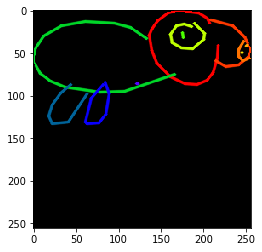

In [229]:
def Strokes_to_RGB():
    strokes = df['drawing'][1014]
    print(len(strokes))
    img = np.zeros((BASE_SIZE, BASE_SIZE, 3), np.uint8)

    colors = n_color(len(strokes))

    for t, stroke in enumerate(strokes):
        color = colors[t]
        for i in range(len(stroke[0]) - 1):
            cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 
                     color=color, thickness=2, lineType=cv2.LINE_AA)
plt.imshow(img)
cv2.imwrite('test.jpg', img)

In [48]:
def test_generator(img_size, batchsize, lw=6):
    while True:
        for df in pd.read_csv(path, chunksize=batchsize):
            df['drawing'] = df['drawing'].apply(ast.literal_eval)
            x = np.zeros((len(df), img_size, img_size, 3))
            for i, raw_strokes in enumerate(df.drawing.values):
                x[i, :, :, :] = draw_cv2(raw_strokes, size=img_size, lw=lw)
            yield x, preprocess_input(x).astype(np.float32)

In [47]:
def draw_cv2(raw_strokes, size=256, lw=7, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE, 3), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = colors[min(t, len(colors)-1)]
            cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw, lineType=cv2.LINE_AA)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

In [49]:
test_datagen = test_generator(img_size, batchsize, line_width)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

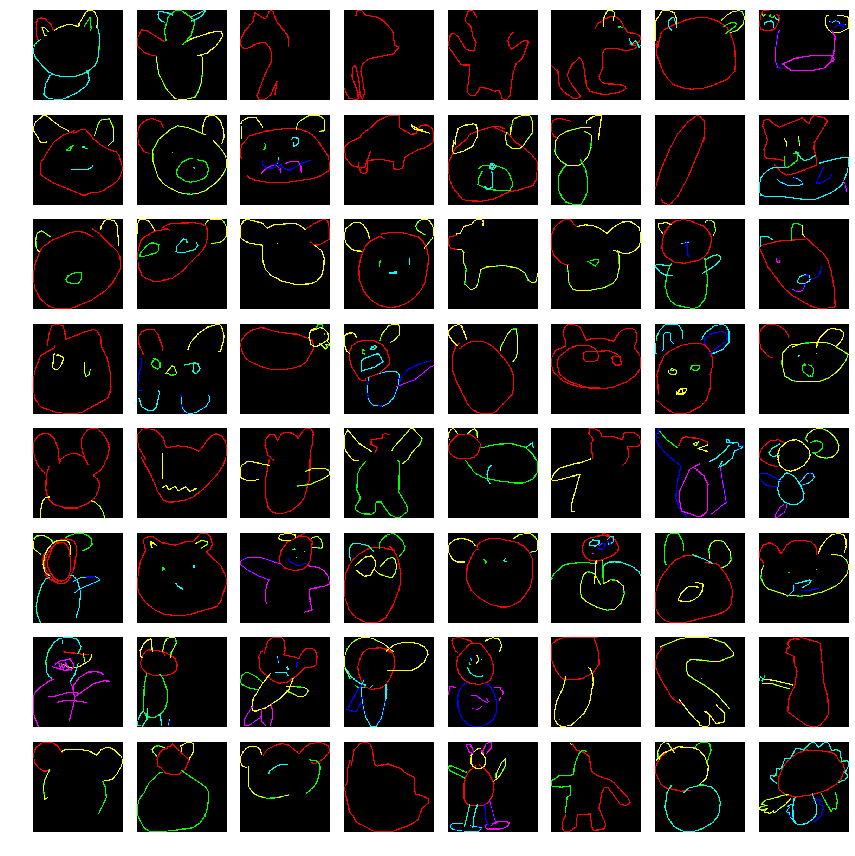

In [50]:
x, xi = next(test_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    ax.imshow(x[i])
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();